In [1]:
import pickle
from datasets import load_dataset
import numpy as np


multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20230518")
modified_dataset = multi_lexsum["test"].filter(lambda x: x["summary/short"] != None)

In [2]:
import evaluate

rouge_scoring = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

In [3]:
import os
import json
def load_predicted_data(path):
    predicted = []
    ordered_files = os.listdir(path)
    ordered_files = sorted(ordered_files, key = lambda x: int(x.split(".")[0]))
    for file in ordered_files:
        predicted.append(json.load(open(path+file, "r"))[-1]["content"])

    return predicted

In [4]:
import os
from collections import defaultdict

## ROUGE
# ['led: rouge1: 48.77', 'led: rouge2: 25.24', 'led: rougeL: 33.67', 'led: rougeLsum: 33.94']
# ['primera: rouge1: 45.74', 'primera: rouge2: 22.83', 'primera: rougeL: 31.92', 'primera: rougeLsum: 32.18']

### BERTScore
# ['led: precision: 0.74', 'led: recall: 0.61', 'led: f1: 0.67']
# ['primera: precision: 0.74', 'primera: recall: 0.62', 'primera: f1: 0.68']

results = {"model": [], "selection_type": [], "prompt_type": [], "score_value": [], "score_type": []}
for model in os.listdir("answers/"):
    for prompt_type in os.listdir(f"answers/{model}/"):
        for selection_type in os.listdir(f"answers/{model}/{prompt_type}/"):
            predicted = load_predicted_data(f"answers/{model}/{prompt_type}/{selection_type}/")
            bert_scores = bertscore.compute(predictions=predicted, references=modified_dataset["summary/short"][:len(predicted)], model_type="microsoft/deberta-large-mnli", batch_size = 10)
            r_scores = rouge_scoring.compute(predictions=predicted, references=modified_dataset["summary/short"][:len(predicted)], use_stemmer = True)
            
            r_scores = {metric: round(np.mean(val), 3) for metric, val in r_scores.items()}
            bert_scores = {metric: round(np.mean(val[0]), 3) for metric, val in bert_scores.items() if metric != "hashcode"}
            
            results["model"] += [model] * 4
            results["selection_type"] += [selection_type] * 4
            results["prompt_type"] += [prompt_type] * 4
            results["score_value"] += [r_scores["rouge1"], r_scores["rouge2"], r_scores["rougeL"], bert_scores["f1"]]
            results["score_type"] += ["rouge1", "rouge2", "rougeL", "bert_score"]

/home/keddie/anaconda3/envs/facilex_caselaw/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
import pickle

ext_results = pickle.load(open("ext_results.pickle", "rb"))

In [6]:
ext_results.keys()

dict_keys(['score_value', 'score_type', 'type', 'sentences'])

In [7]:
print(len(ext_results["score_type"]))

80


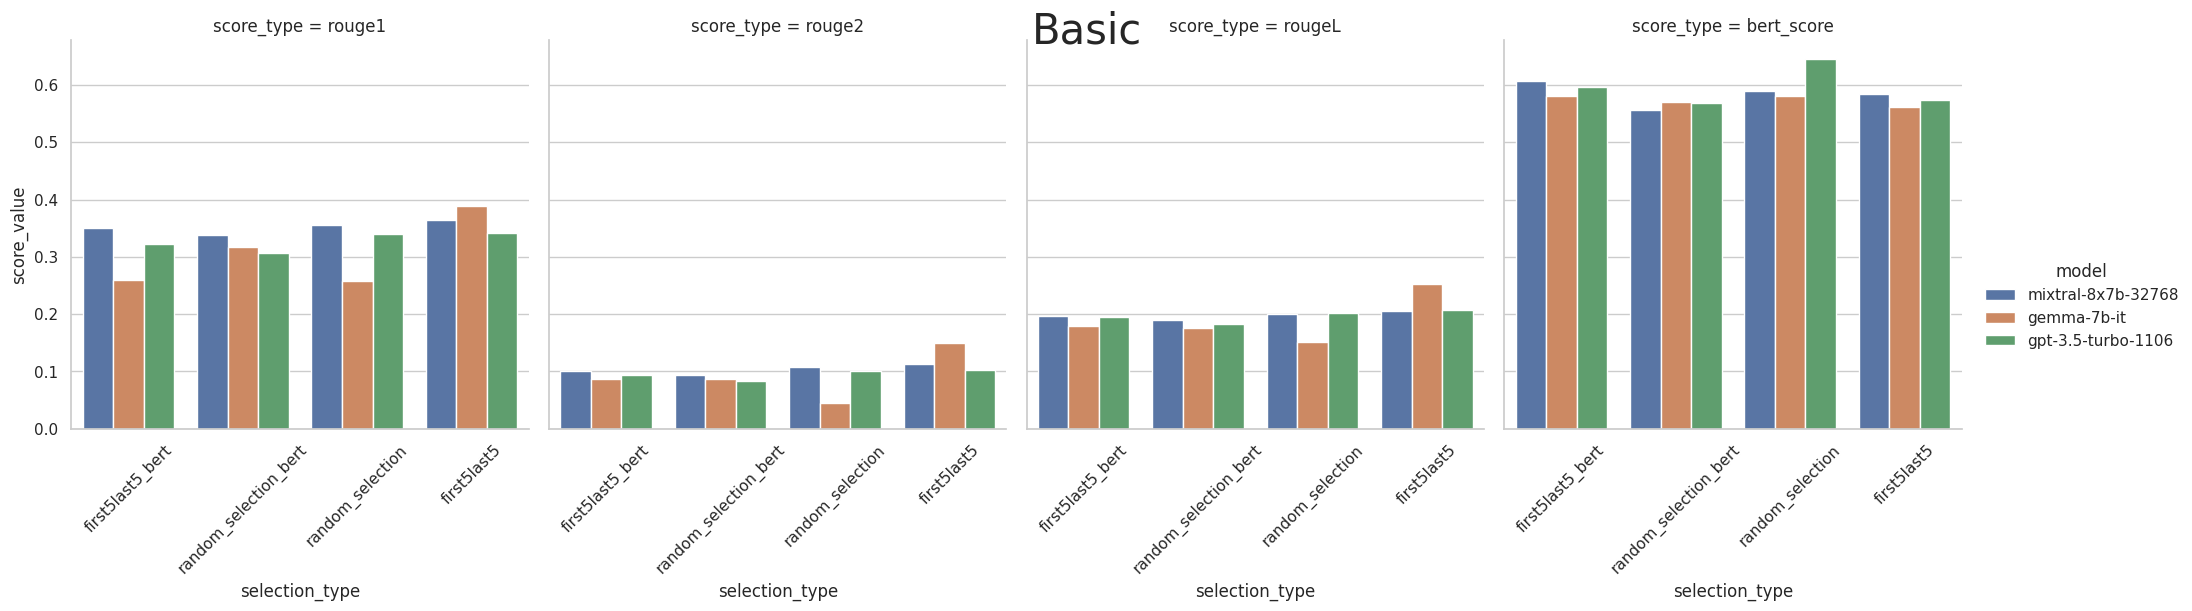

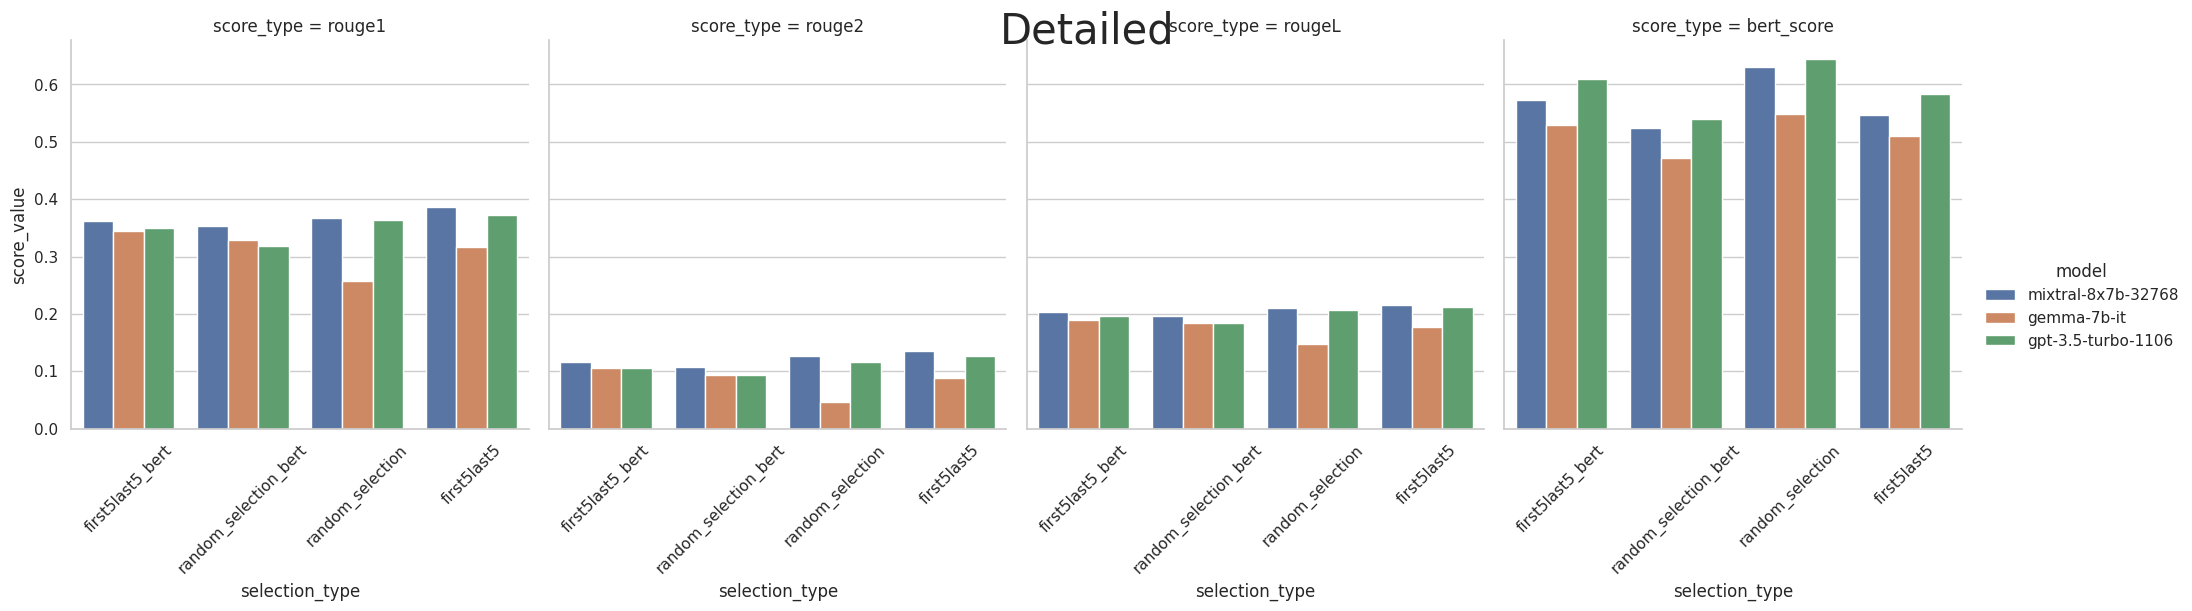

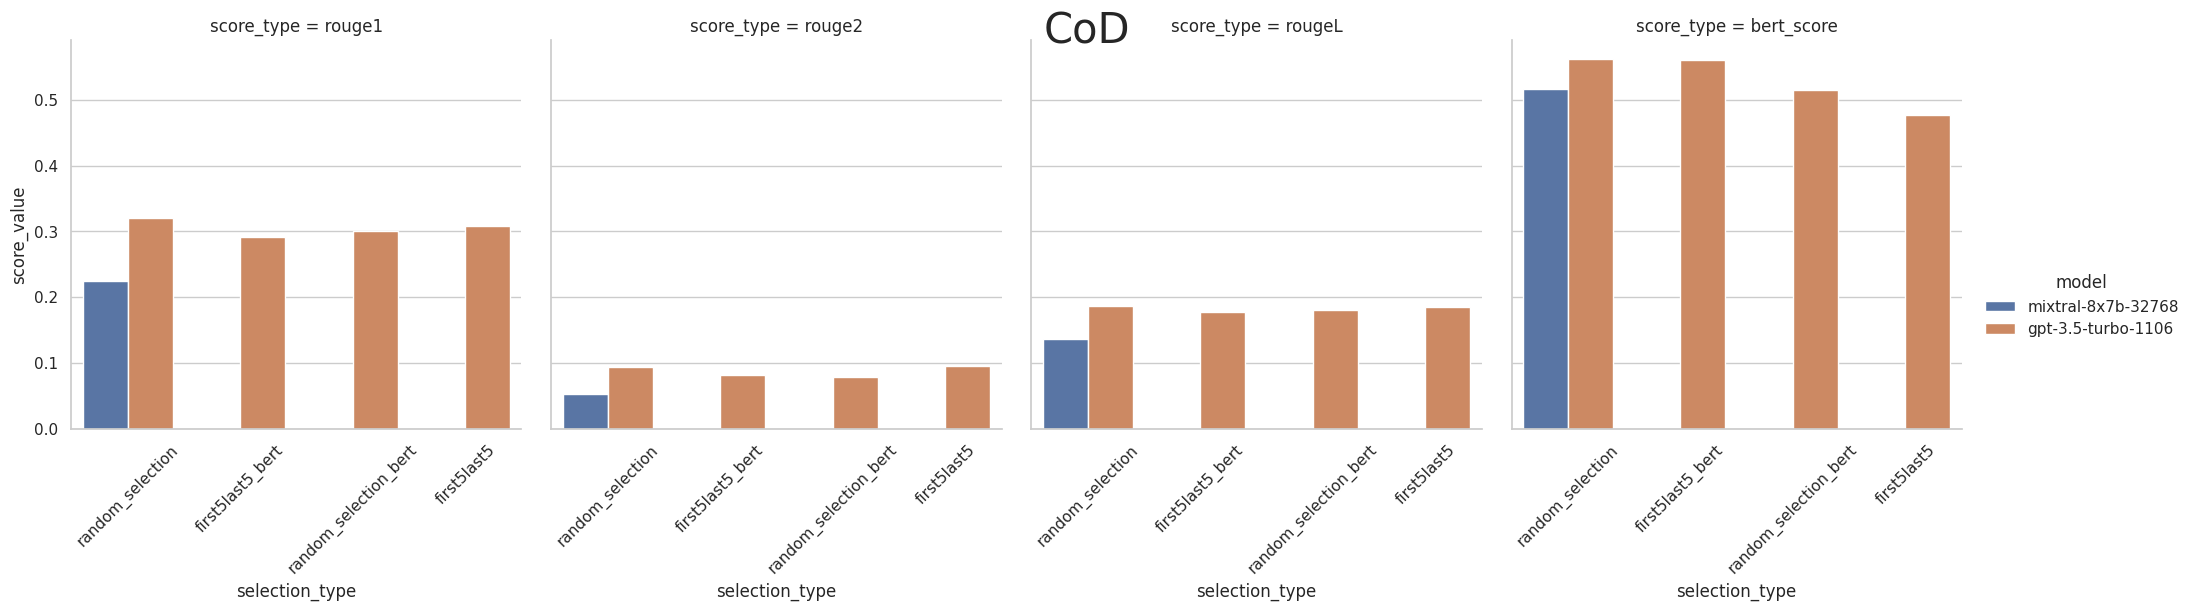

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_results = pd.DataFrame(results)
# df_results = df_results[df_results["model"] == "gpt-3.5-turbo-1106"]

sns.set_theme(style = "whitegrid")
plot = sns.catplot(kind = "bar", data = df_results[df_results["prompt_type"] == "basic"], x = "selection_type", y = "score_value", hue = "model", col = "score_type")
plot.set_xticklabels(rotation = 45)
plt.suptitle("Basic", fontsize=30)
plt.show()
plot = sns.catplot(kind = "bar", data = df_results[df_results["prompt_type"] == "detailed"], x = "selection_type", y = "score_value", hue = "model", col = "score_type")
plot.set_xticklabels(rotation = 45)
plt.suptitle("Detailed", fontsize=30)
plt.show()
plot = sns.catplot(kind = "bar", data = df_results[df_results["prompt_type"] == "cod"], x = "selection_type", y = "score_value", hue = "model", col = "score_type")
plot.set_xticklabels(rotation = 45)
plt.suptitle("CoD", fontsize=30)
plt.show()